### Max Depth GridSearch

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# machine learning
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import plot_importance, plot_tree
from math import sqrt
from sklearn.model_selection import train_test_split, KFold, cross_val_score ,RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFE
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

### Load and view data

In [ ]:
OD = pd.read_excel("../Updated Variable list github/gabe/Modeling/Outputs/all_riders_vars_dataframe.xlsx").drop('Unnamed: 0', axis=1)

* Split the dataset into train, test, and val set

In [110]:
pd.reset_option('all')
# pd.set_option('display.max_rows', None)

In [111]:
OD = OD.groupby('pairs').first().reset_index()

In [112]:
OD.rename({'proportionhouses_O': 'proportion_of_households_O', 
           'proportionhouses_D': 'proportion_of_households_D'}, axis=1, inplace=True)

In [113]:
OD.head()

,pairs,passengers,ID_D,PRIMARY_NAME_FY23_D,walkshed_filename_D,WMATA_filename_D,track_miles_names_D,auto_filename_D,ID_O,PRIMARY_NAME_FY23_O,...,prox3norm_O,conn6norm_O,parks2norm_O,peds4norm_O,safenorm_O,traffic5norm_O,aesttot3norm_O,paf2norm_O,sop7norm_O,urban_dummy_O
0,MSTN_0010MSTN_002,1418,MSTN_002,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,Archives-Navy Memorial,Archives,ARCHIVES-NAVY MEMORIAL-PENN QUARTER,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
1,MSTN_0010MSTN_003,156,MSTN_003,Benning Road,BENNING ROAD,Benning Road,Benning Road,BENNING ROAD,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
2,MSTN_0010MSTN_004,425,MSTN_004,Brookland-CUA,BROOKLAND-CUA,Brookland,Brookland-CUA,BROOKLAND-CUA,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
3,MSTN_0010MSTN_005,146,MSTN_005,Capitol South,CAPITOL SOUTH,Capitol South,Capitol South,CAPITOL SOUTH,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0
4,MSTN_0010MSTN_006,124,MSTN_006,Cleveland Park,CLEVELAND PARK,Cleveland Park,Cleveland Park,CLEVELAND PARK,MSTN_001,Anacostia,...,10.285137,75.577863,3.443532,31.693741,77.080763,54.616166,50.629299,0.34611,47.471791,0


In [114]:
OD.shape

(8187, 148)

In [115]:
OD.drop(['pairs', 'ID_D', 'PRIMARY_NAME_FY23_D', 'walkshed_filename_D', 'WMATA_filename_D', 
           'track_miles_names_D', 'auto_filename_D', 'ID_O', 'PRIMARY_NAME_FY23_O', 'walkshed_filename_O', 
             'WMATA_filename_O', 'track_miles_names_O', 'auto_filename_O', 'O', 'D',
             'MSTN_ID_D', 'STATION_ID_D', 'MSTN_D', 'MSTN_ID_O', 'STATION_ID_O', 'MSTN_O', 
              'Total Households_O', 'Total Households_D', 'COMP_MILE', 'track_miles', 'SD_FARE', 'TRAVEL_TIME', 'pub_admin_jobs_O', 
            'pub_admin_jobs_D', 'bus_tt_per_mile', 'am_parking_user', 'pm_parking_user', 'off_parking_user', 'peak_fare_per_mile2',
            'off_peak_fare_per_mile', 'google_driving_miles', 'am_new_auto_tt_per_mile2', 'pm_new_auto_tt_per_mile2', 'off_new_auto_tt_per_mile2',
             'OFF_PEAK_FARE', 'PEAK_FARE', 'HH_1_car_O', 'HH_1_car_D', 'HH_more1_car_O', 'HH_more1_car_D', 'Name_1_D_D', 'Name_1_O_D', 
             'Name_1_D_O', 'Name_1_O_O'
          ], axis=1, inplace=True)  # Include in  O_MSTN_ID and D_MSTN_ID

OD.shape

(8187, 99)

### Preprocessing

In [116]:
X = OD.drop('passengers', axis=1)
y = OD['passengers']

In [117]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.reset_option('all')

In [118]:
X.isna().any().sum()

30

In [119]:
y.isna().any().sum()

0

In [120]:
X = X.fillna(0.000001)

### Remove highly collinear variables

* 16 of these variables were dropped and due to very high multicollinearity and risk of endogeneity problem

In [121]:
# Xcorr = X.corr()
# plt.figure(figsize=(35, 30))
# sns.heatmap(Xcorr, cmap='coolwarm')

In [124]:
# sorted(X1.columns.to_list())
X1.shape

(8187, 57)

In [125]:
X1 = X.copy()

X1 = X1.drop(['All_Jobs_O', 'All_Jobs_D', 'ctpp_jobs_O', 'ctpp_jobs_D', 'urban_dummy_O', 'urban_dummy_D', 'terminal_dummy_2023_O', 
              'terminal_dummy_2023_D', 'AM_AVG_TRAINS_O',  'AM_AVG_TRAINS_D', 'PM_AVG_TRAINS_O', 'PM_AVG_TRAINS_D', 'am_new_auto_tt2', 
              'pm_new_auto_tt2', 'off_new_auto_tt2','bus_transit_minutes', 'aesttot3norm_D', 'aesttot3norm_O', 'conn6norm_D', 'conn6norm_O',
             'dens2norm_D', 'dens2norm_O', 'form3norm_D', 'form3norm_O', 'paf2norm_D', 'paf2norm_O', 'parks2norm_D', 'parks2norm_O', 
              'peds4norm_D', 'peds4norm_O', 'prox3norm_D', 'prox3norm_O', 'safenorm_D', 'safenorm_O', 'sop7norm_D', 'sop7norm_O', 
             'traffic5norm_D', 'traffic5norm_O', 'bikelane_D', 'bikelane_O', 'metro_transit_minutes' ], axis=1)


In [ ]:
# corr_matrix1 = X1.corr()
# plt.figure(figsize=(35, 30))
# mask1 = np.triu(np.ones_like(corr_matrix1, dtype=bool))
# sns.heatmap(corr_matrix1, mask=mask1, annot=True, fmt='.1f', cmap='coolwarm', cbar=True)
# plt.savefig('1corr_mat.png')
# plt.show()

In [ ]:
# mask1 = (corr_matrix1 > 0.6) & (corr_matrix1 < 1)
# pairs1 = corr_matrix[mask1].stack().reset_index()
# pairs1.columns = ['Variable1', 'Variable2', 'Correlation']
# pairs1.sort_values(by='Correlation', ascending=False).reset_index(drop=True)

In [ ]:
# vif_data1 = pd.DataFrame()
# vif_data1["feature"] = X1.columns

# vif_data1["VIF"] = [variance_inflation_factor(X1.values, i) for i in range(len(X1.columns))]

# vif_data1["VIF"] = vif_data1["VIF"].astype('float')
# vif_data1 = vif_data1.sort_values(by='VIF').reset_index(drop=True)
# vif_data1["VIF"] = vif_data1["VIF"].astype('str')
# vif_data1

### Modelling

In [ ]:
pd.reset_option('all')

In [ ]:
X1.shape

#### RFE feature set 30-55 : 5

In [ ]:
feat_dic = {30: ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
                'metro_transit_minutes', 'bus_competativeness_index',
                'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
                'PARKING_CAPACITY_D', 'bus_line_count_D', 'distance_to_core_D',
                'Proportion_night_weekend_jobs_D', 'Total_Nine_to_Five_workers_D',
                'Proportion_education_jobs_D', 'bike_cap_D', 'hotelcount_D',
                'restaurantcount_D', 'intercityhub_D', 'HH_0_car_D',
                'ALLPERIODS_AVG_TRAINS_O', 'proportion_of_households_O',
                'PARKING_CAPACITY_O', 'distance_to_core_O',
                'Total_Nine_to_Five_workers_O', 'Median_household_income_O',
                'bike_cap_O', 'hotelcount_O', 'restaurantcount_O', 'intercityhub_O',
                'prop_str_dens_O', 'HH_0_car_O'], 
            40: ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
                'metro_transit_minutes', 'bus_competativeness_index',
                'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
                'PARKING_CAPACITY_D', 'bus_line_count_D', 'bus_stop_count_D',
                'distance_to_core_D', 'Proportion_night_weekend_jobs_D',
                'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
                'Median_household_income_D', 'bike_cap_D', 'hotelcount_D',
                'restaurantcount_D', 'intercityhub_D', 'prop_str_dens_D', 'HH_0_car_D',
                'housing_units_afford_D', 'ALLPERIODS_AVG_TRAINS_O',
                'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O',
                'distance_to_core_O', 'Proportion_night_weekend_jobs_O',
                'Total_Nine_to_Five_workers_O', 'Proportion_education_jobs_O',
                'Median_household_income_O', 'bike_cap_O', 'hotelcount_O',
                'entertainmentcount_O', 'restaurantcount_O', 'intercityhub_O',
                'prop_str_dens_O', 'Jobs_transit_O', 'HH_0_car_O',
                'housing_units_afford_O'], 
            45: ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
                'metro_transit_minutes', 'bus_competativeness_index',
                'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
                'PARKING_CAPACITY_D', 'bus_line_count_D', 'bus_stop_count_D',
                'distance_to_core_D', 'Proportion_night_weekend_jobs_D',
                'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
                'Median_household_income_D', 'bike_cap_D', 'hotelcount_D',
                'entertainmentcount_D', 'restaurantcount_D', 'intercityhub_D',
                'prop_str_dens_D', 'Jobs_transit_D', 'highschoolenroll_D', 'HH_0_car_D',
                'housing_units_afford_D', 'ALLPERIODS_AVG_TRAINS_O',
                'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O',
                'bus_stop_count_O', 'distance_to_core_O',
                'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
                'Proportion_education_jobs_O', 'Median_household_income_O',
                'bike_cap_O', 'HH_below_50k_O', 'hotelcount_O', 'entertainmentcount_O',
                'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O',
                'Jobs_transit_O', 'HH_0_car_O', 'housing_units_afford_O'], 
            50: ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
                'metro_transit_minutes', 'bus_competativeness_index',
                'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
                'PARKING_CAPACITY_D', 'bus_line_count_D', 'bus_stop_count_D',
                'distance_to_core_D', 'Proportion_night_weekend_jobs_D',
                'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
                'Median_household_income_D', 'bike_cap_D', 'HH_below_50k_D',
                'hotelcount_D', 'entertainmentcount_D', 'restaurantcount_D',
                'intercityhub_D', 'prop_str_dens_D', 'Jobs_transit_D',
                'convenience_storecount_D', 'highschoolenroll_D', 'college_enroll_D',
                'HH_0_car_D', 'housing_units_afford_D', 'ALLPERIODS_AVG_TRAINS_O',
                'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O',
                'bus_stop_count_O', 'distance_to_core_O',
                'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
                'Proportion_education_jobs_O', 'Median_household_income_O',
                'bike_cap_O', 'HH_below_50k_O', 'hotelcount_O', 'entertainmentcount_O',
                'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O',
                'Jobs_transit_O', 'highschoolenroll_O', 'college_enroll_O',
                'HH_0_car_O', 'housing_units_afford_O'], 
            55: ['bus_tt', 'bike_traveltime', 'google_driving_minutes',
                'metro_transit_minutes', 'bus_competativeness_index',
                'ALLPERIODS_AVG_TRAINS_D', 'proportion_of_households_D',
                'PARKING_CAPACITY_D', 'bus_line_count_D', 'bus_stop_count_D',
                'distance_to_core_D', 'Proportion_night_weekend_jobs_D',
                'Total_Nine_to_Five_workers_D', 'Proportion_education_jobs_D',
                'Median_household_income_D', 'bike_cap_D', 'HH_below_50k_D',
                'hotelcount_D', 'entertainmentcount_D', 'restaurantcount_D',
                'intercityhub_D', 'prop_str_dens_D', 'Jobs_transit_D',
                'convenience_storecount_D', 'highschoolenroll_D', 'college_enroll_D',
                'High_School_hh_D', 'college_hh_D', 'HH_0_car_D',
                'housing_units_afford_D', 'ALLPERIODS_AVG_TRAINS_O',
                'proportion_of_households_O', 'PARKING_CAPACITY_O', 'bus_line_count_O',
                'bus_stop_count_O', 'distance_to_core_O',
                'Proportion_night_weekend_jobs_O', 'Total_Nine_to_Five_workers_O',
                'Proportion_education_jobs_O', 'Median_household_income_O',
                'bike_cap_O', 'HH_below_50k_O', 'hotelcount_O', 'entertainmentcount_O',
                'restaurantcount_O', 'intercityhub_O', 'prop_str_dens_O',
                'Jobs_transit_O', 'convenience_storecount_O', 'highschoolenroll_O',
                'college_enroll_O', 'High_School_hh_O', 'college_hh_O', 'HH_0_car_O',
                'housing_units_afford_O']
                   
           }



#### Varying max depth from 20 - 500

In [ ]:
for k,v in feat_dic.items():
    feat_dic[k] = X1[feat_dic[k]]

In [ ]:
rmse, r2, bestparams = {}, {}, {}
gridr2, gridrmse, test_r2, test_rmse = {}, {}, {}, {}

param_grid = {
    'max_depth': [None] + list(np.arange(20, 520, 20)),  # from 50 - 1500
}

for k, v in tqdm(feat_dic.items(), desc='Gridsearch Progress'):
    # Initialize inner dictionaries
    rmse[k], r2[k], gridrmse[k], gridr2[k], test_rmse[k], test_r2[k], bestparams[k] = {}, {}, {}, {}, {}, {}, {}

    # Split the data
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(v, y, test_size=0.10, random_state=10)
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.15, random_state=10)

    # Simple model training and validation
    for max_d in param_grid['max_depth']:
        simple_model = RandomForestRegressor(max_depth=max_d, random_state=10)
        simple_model.fit(X_train, y_train)
        y_pred_val = simple_model.predict(X_val)
        rmse[k][max_d] = sqrt(mean_squared_error(y_val, y_pred_val))
        r2[k][max_d] = np.round(r2_score(y_val, y_pred_val), 3)

    # Grid search
    regr_model = RandomForestRegressor(random_state=10)
    grid_search = GridSearchCV(estimator=regr_model, param_grid=param_grid, scoring='r2', cv=5, verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Store best parameters and perform evaluation using them
    best_max_depth = grid_search.best_params_['max_depth']
    bestparams[k] = {'max_depth': best_max_depth}
    
    # Reevaluate on validation set with the best found parameters
    y_pred_val = grid_search.predict(X_val)
    gridrmse[k][best_max_depth] = sqrt(mean_squared_error(y_val, y_pred_val))
    gridr2[k][best_max_depth] = np.round(r2_score(y_val, y_pred_val), 3)

    # Evaluation on test set
    y_pred_test = grid_search.predict(X_test)
    test_rmse[k][best_max_depth] = sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2[k][best_max_depth] = np.round(r2_score(y_test, y_pred_test), 3)


In [ ]:
r2

In [ ]:
bestparams

In [ ]:
sns.set_theme(style='darkgrid') 
sns.lineplot(x=r2[55].keys(), y=r2[55].values())
plt.title('(55 Features) Max Depth vs R2')
plt.xlabel('Tree Depth')
plt.ylabel('R2')
plt.savefig('Tuning/55depthR2.jpg')
plt.show()
# plt.xticks(np.arange(50, 1550, 100))

In [126]:
model_data = pd.concat([X1, y], axis=1)

In [134]:
model_data.to_csv('model_data.csv', index=False)

In [ ]:
X1.to_csv('features.csv', index=False), y.to_csv('label.csv', index=False)

#### Training model with Empirical TT feature

In [75]:
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X1, y, test_size=0.10, random_state = 10)

In [76]:
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.15, random_state=10)

In [77]:
X_train.shape, X_val.shape, X_test.shape

((6262, 55), (1106, 55), (819, 55))

In [86]:
tf25 = ['ALLPERIODS_AVG_TRAINS_D','ALLPERIODS_AVG_TRAINS_O','HH_0_car_D','HH_0_car_O','PARKING_CAPACITY_D','PARKING_CAPACITY_O',
        'Proportion_education_jobs_D','Total_Nine_to_Five_workers_D','Total_Nine_to_Five_workers_O','bike_cap_D','bike_cap_O'
        ,'bike_traveltime','bus_competativeness_index','bus_tt','distance_to_core_D','distance_to_core_O','google_driving_minutes',
        'intercityhub_D','intercityhub_O','trip_time_mins','prop_str_dens_O','proportion_of_households_D','proportion_of_households_O',
        'restaurantcount_D','restaurantcount_O']

In [87]:
X_train = X_train[tf25]
X_test = X_test[tf25]
X_val = X_val[tf25]

In [88]:
regr = RandomForestRegressor(random_state=10)

In [89]:
regr.fit(X_train, y_train)


RandomForestRegressor(random_state=10)

In [90]:
y_pred = regr.predict(X_val)

In [91]:
rmse = sqrt(mean_squared_error(y_val, y_pred))
rmse

652.099536619944

In [92]:
np.round(r2_score(y_val, y_pred), 3)

0.739

In [93]:
kfold = KFold(n_splits=5, shuffle=True, random_state=10)

reg = RandomForestRegressor(random_state=10)

scores = cross_val_score(reg, X1, y, cv=kfold, scoring='r2')


In [94]:
print(f"R-squared: {scores.mean():.2f}")

R-squared: 0.73


### Generate Feature Importance Metric

In [95]:
importances = regr.feature_importances_

In [96]:
importances

array([0.01721741, 0.01420299, 0.02594423, 0.01299907, 0.0151963 ,
       0.01728294, 0.01612414, 0.01876236, 0.02745314, 0.01791339,
       0.01687323, 0.06980259, 0.03891692, 0.02163108, 0.02603807,
       0.02079324, 0.05048608, 0.05677588, 0.07135536, 0.35978703,
       0.01299303, 0.01955864, 0.01942037, 0.0161259 , 0.01634664])

In [97]:
indices = np.argsort(importances)[::-1][:10]

In [ ]:
indices

In [98]:
names = [X_train.columns[i] for i in indices]

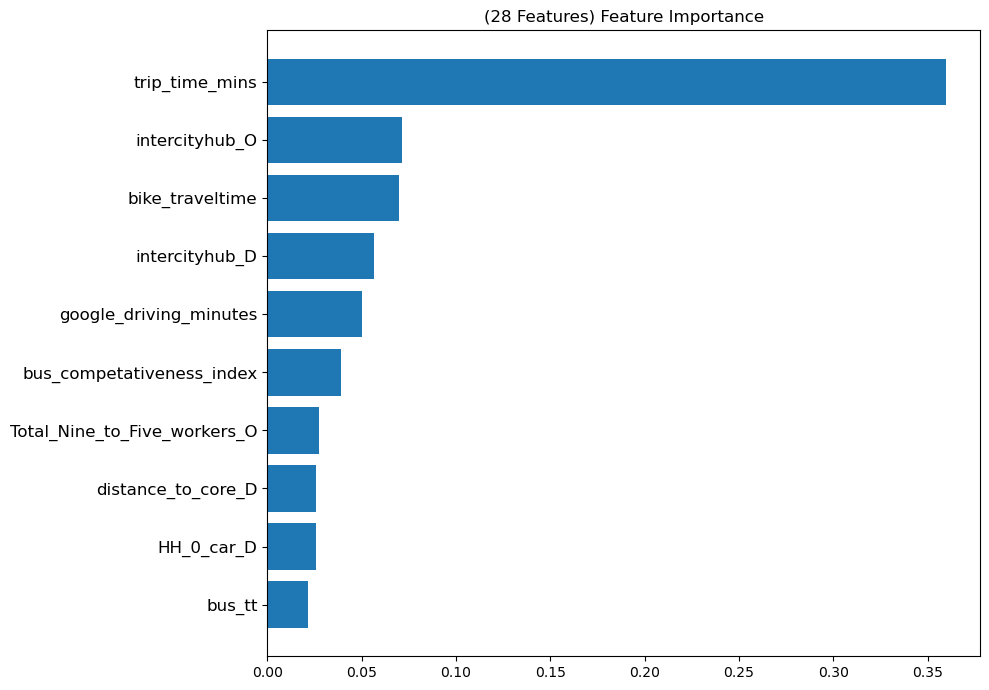

In [99]:
plt.figure(figsize=(10, 7))
plt.title("(28 Features) Feature Importance")
plt.barh(range(10), importances[indices], align='center')
plt.yticks(range(10), names, size=12)
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance at the top
plt.tight_layout()
# plt.savefig('Feature_importance/20 features importance.jpg')
plt.show()